In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

**Adjust the path to your project below**

In [2]:
%run -n /path/to/your/project
print(config['paramlist'])

(('gamma', array([-1.5 , -1.45, -1.4 , -1.35, -1.3 , -1.25, -1.2 , -1.15, -1.1 ,
       -1.05, -1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65,
       -0.6 , -0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 ,
       -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,
        0.3 ,  0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,
        0.75,  0.8 ,  0.85,  0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,
        1.2 ,  1.25,  1.3 ,  1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,
        1.65,  1.7 ,  1.75,  1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,
        2.1 ,  2.15,  2.2 ,  2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ])), ('rmax', array([3.16227766e+08, 3.54813389e+08, 3.98107171e+08, 4.46683592e+08,
       5.01187234e+08, 5.62341325e+08, 6.30957344e+08, 7.07945784e+08,
       7.94328235e+08, 8.91250938e+08, 1.00000000e+09, 1.12201845e+09,
       1.25892541e+09, 1.41253754e+09, 1.58489319e+09, 1.77827941e+09,
       1.99526231e+09, 2.23872114e+09, 2.51188643e+09, 2.818382

## Check the config for this project

In [3]:
import os
figdir = './figures_'+config['project_tag']
try:
    os.mkdir(figdir)
except:
    pass
template = figdir + '/fig_'+config['project_tag']+'_{:}.png'

In [4]:
print(config['project_tag'])

scan3D_talys


**Adjust the path to your project below**

In [5]:
%load -s single_run,setup_run /path/to/your/project/run.py

# Plot Definitions

In [6]:
# %load ../scripts/cr_plot.py

from analyzer.spectra import auger2015, auger2017

def plot_cosmic_rays(result, deltaE=0.,data=auger2017,data_label='Auger 2017'):
    import matplotlib.pyplot as plt
    from prince.util import get_AZN
    
    A = lambda x: get_AZN(x)[0]

    for group, color, label, loffset in zip([(A,1,1),(A,2,4),(A,5,14),(A,15,28),(A,29,56)],
                                 ['red','gray','green','orange','blue'],
                                 [r'$\mathrm{A} = 1$',r'$2 \leq \mathrm{A} \leq 4$',r'$5 \leq \mathrm{A} \leq 14$',
                                  r'$15 \leq \mathrm{A} \leq 28$','$29 \leq \mathrm{A} \leq 56$'],
                                 [0, 0, 0 , 0, 0]):
#         if color == 'blue':
#             continue

        energy, spectrum = result.get_solution_group(group)
        energy *= 1 + deltaE
        l = plt.loglog(energy, spectrum, label=label, c=color, alpha = 0.6)
        maxidx = spectrum.argmax()
        plt.annotate(label, (energy[maxidx+loffset], spectrum[maxidx+loffset] / 1.5),color=color, weight = 'bold', fontsize = 10,
                    horizontalalignment='center', verticalalignment='top')

    energy, spectrum = result.get_solution_group('CR')
    energy *= 1 + deltaE
    l = plt.loglog(energy, spectrum, c='saddlebrown')

    plt.errorbar(data['energy'], data['spectrum'],
                 yerr=(data['lower_err'], data['upper_err']),
                 fmt='o', color='black', label = data_label,markersize=3)
    plt.annotate(data_label,(data['energy'][-4],data['spectrum'][-4]*1.5),fontsize=12,
                 horizontalalignment='left', verticalalignment='bottom')
#     plt.legend(ncol=1, loc='lower left', fontsize='small')

    plt.xlim(5e8,5e11)
    plt.ylim(1e0,1e3)

    plt.ylabel('E$^3$ J [GeV$^{2}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
    plt.xlabel('E [GeV]')

In [7]:
# %load ../scripts/xmax_plot.py
def make_error_boxes(xdata, ydata, xerror, yerror, facecolor='r',
                     edgecolor='None', alpha=0.5):

    ax = plt.gca()
    from matplotlib.collections import PatchCollection
    from matplotlib.patches import Rectangle

    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T):
        rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
        errorboxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)

    # Add collection to axes
    ax.add_collection(pc)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

from analyzer.xmax import XmaxSimple
from analyzer.spectra import Xmax2015,Xmax2017,XRMS2015,XRMS2017

def plot_xmax_mean(result, deltaE = 0.,xshift=0.,
                   model=XmaxSimple(model=XmaxSimple.EPOSLHC),
                   data=Xmax2017, data_label=r'\langle Xmax \rangle Auger 2017'):

    egrid, average, variance = result.get_lnA([el for el in result.known_species if el >= 100])
    energy = egrid
    energy *= 1 + deltaE
    mean_lnA = average
    sigma_lnA = variance

    import matplotlib.pyplot as plt
    # plot the reference models
    for A, c, name in zip([1,4,14,56], ['red','gray','green','blue'],['H','He','N','Fe']):
        Xmax = model.get_mean_Xmax(np.log(A), energy)
        plt.semilogx(energy,Xmax, color = c)
        idx = find_nearest(energy,1e11)
        plt.annotate(name,(energy[idx+1],Xmax[idx]),color = c,annotation_clip=False)

    Xmax = model.get_mean_Xmax(mean_lnA, energy)
    plt.semilogx(energy, Xmax, color = 'saddlebrown', ls ='solid')

    xerr = np.array((data['energy_Low'], data['energy_Up']))
    yerr = np.array((data['sys_Low'], data['sys_Up']))
    make_error_boxes(data['energy'], data['val'], xerr, yerr, facecolor='gray')
    
    if xshift > 0:
        xcorr = xshift * data['sys_Up']
    else:
        xcorr = xshift * data['sys_Low']

    plt.errorbar(data['energy'], data['val'] + xcorr,
                 xerr=(data['energy_Low'], data['energy_Up']),
                 yerr=(data['stat'], data['stat']),
                 fmt='o',markersize=2.5, label=data_label, c='black')

    plt.xlim(1e9,1e11)
    plt.ylim(600,900)
    plt.xlabel('E  [GeV]')
    plt.ylabel(r'$\langle X_{max} \rangle$ [g cm$^{-2}$]')
    
def plot_xmax_sigma(result, deltaE = 0.,xshift=0.,
                    model=XmaxSimple(model=XmaxSimple.EPOSLHC),
                    data=XRMS2017, data_label=r'\langle Xmax \rangle Auger 2017'):
    
    egrid, average, variance = result.get_lnA([el for el in result.known_species if el >= 100])
    energy = egrid
    energy *= 1 + deltaE
    mean_lnA = average
    var_lnA = variance

    import matplotlib.pyplot as plt
    for A, c, name in zip([1,4,14,56], ['red','gray','green','blue'],['H','He','N','Fe']):
        sigmaXmax, sigmaXmax_part = np.sqrt(model.get_var_Xmax(np.log(A), 0., energy))
        plt.semilogx(energy,sigmaXmax, color = c)
        idx = find_nearest(energy,1e11)
        plt.annotate(name,(energy[idx+1],sigmaXmax[idx]),color = c,annotation_clip=False)

    sigmaXmax, sigmaXmax_part = np.sqrt(model.get_var_Xmax(mean_lnA, var_lnA, energy))
    plt.semilogx(energy,sigmaXmax, color = 'saddlebrown', ls ='solid')
#     plt.semilogx(energy,sigmaXmax_part, color = 'saddlebrown', ls ='dashed')

    xerr = np.array((data['energy_Low'], data['energy_Up']))
    yerr = np.array((data['sys_Low'], data['sys_Up']))
    make_error_boxes(data['energy'], data['val'], xerr, yerr, facecolor='gray')
    
    if xshift > 0:
        xcorr = xshift * data['sys_Up']
    else:
        xcorr = xshift * data['sys_Low']
    
    plt.errorbar(data['energy'], data['val'] + xcorr,
                 xerr=(data['energy_Low'], data['energy_Up']),
                 yerr=(data['stat'], data['stat']),
                 fmt='o',markersize=2.5, label='Xmax Auger 2015', c='black')
    
    plt.xlim(1e9,1e11)
    plt.ylim(0,70)
    plt.xlabel('E  [GeV]')
    plt.ylabel(r'$\sigma( X_{max})$ [g cm$^{-2}$]')

# Show scan summary

**Adjust the path to your project below**

In [8]:
from os import path
filepath = path.join('/path/to/your/project','collected.hdf5')
input_spec = np.array([101,402,1407,2814,5626])
# paramlist = tuple((key,value) for key,value in config['paramlist'].items())
paramlist = config['paramlist']

from analyzer.plotter import ScanPlotter
scan = ScanPlotter(filepath, input_spec, paramlist, fit ='floating_E_Sibyll_2017')

# prince_run = setup_run()
# scan.comp_lum_frac(prince_run,pbar=True)
scan.print_summary()
print(scan.available)

-----------------------------
| Summary:                  |
-----------------------------
| Best fit chi2:  27.033635718535315
| at parameters:  (-0.7999999999999999, 1584893192.4611108, 4.200000000000001)
| norm:           6.463951060661838e-46
| E-shift         0.13999999413001019
| xmax-shift      0.0
| fractions:     
| 402 with 82.03 %
| 1407 with 17.31 %
| 2814 with 0.64 %
< 0.1 %: [101, 5626]
[u'default fit', u'egrid', u'floating_E_Emin5e9_Epos', u'floating_E_Emin5e9_Epos_2017', u'floating_E_Emin5e9_QGS', u'floating_E_Emin5e9_QGS_2017', u'floating_E_Emin5e9_Sibyll', u'floating_E_Emin5e9_Sibyll_2017', u'floating_E_Epos', u'floating_E_Epos_2017', u'floating_E_QGS', u'floating_E_QGS_2017', u'floating_E_Sibyll', u'floating_E_Sibyll_2017', u'floating_E_xshift_Epos_2017', u'floating_E_xshift_QGS_2017', u'floating_E_xshift_Sibyll_2017', u'known_spec', u'states']


In [9]:
m, r = scan.recompute_fit(scan.minindex,minimizer_args={'print_level':0, 'fix_deltaE': False,},
                    spectrum_only=False, xmax_model='sibyll',dataset=2017)
print(m.print_fmin())
print(m.print_param())
print(m.args)
print(m.fval)

/afs/ifh.de/group/that/work-jh/packages/PriNCe/prince/solvers.py:118: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/afs/ifh.de/group/that/work-jh/packages/PriNCe/prince/solvers.py:138: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/afs/ifh.de/group/that/work-jh/packages/PriNCe/prince/solvers.py:146: RuntimeWarning: invalid value encountered in divide
  lnA[:, np.newaxis] * spectra).sum(axis=0) / spectra.sum(axis=0)
/afs/ifh.de/group/that/work-jh/packages/PriNCe/prince/solvers.py:148: RuntimeWarning: invalid value encountered in divide
  spectra).sum(axis=0) / spectra.sum(axis=0) - average**2


FCN = 27.0336357185 
 TOTAL NCALL = 1280 
 NCALLS = 1280 
 
 
 EDM = 2.34634112592e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,deltaE,0.14,0.173682,,,-0.14,0.14,No
1,xmax_shift,0,0.2,,,-1,1,Yes
2,norm101,1.16162e-52,4.80318e-46,,,3.57732e-55,3.57732e-43,No
3,norm402,5.30249e-46,1.70497e-46,,,3.57732e-55,3.57732e-43,No
4,norm1407,1.11867e-46,8.13363e-48,,,3.57732e-55,3.57732e-43,No
5,norm2814,4.14918e-48,9.54994e-49,,,3.57732e-55,3.57732e-43,No
6,norm5626,1.29852e-49,5.34096e-50,,,3.57732e-55,3.57732e-43,No


None


+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,deltaE,0.14,0.173682,,,-0.14,0.14,No
1,xmax_shift,0,0.2,,,-1,1,Yes
2,norm101,1.16162e-52,4.80318e-46,,,3.57732e-55,3.57732e-43,No
3,norm402,5.30249e-46,1.70497e-46,,,3.57732e-55,3.57732e-43,No
4,norm1407,1.11867e-46,8.13363e-48,,,3.57732e-55,3.57732e-43,No
5,norm2814,4.14918e-48,9.54994e-49,,,3.57732e-55,3.57732e-43,No
6,norm5626,1.29852e-49,5.34096e-50,,,3.57732e-55,3.57732e-43,No


None
<ArgsView of Minuit at 5568a19e6890>
  0.13999999413
  0.0
  1.16162076356e-52
  5.302489059e-46
  1.11867053557e-46
  4.14917855886e-48
  1.29851888527e-49
27.0336357185


# Parameterspace Plots

In [10]:
scan.index2params(scan.minindex)

(-0.7999999999999999, 1584893192.4611108, 4.200000000000001)

In [11]:
smin_index = (60,22,5)

In [12]:
tmin_index = (42,15,5)

/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/matplotlib/text.py:2096: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "
/afs/ifh.de/group/that/work-jh/anaconda_wgs/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


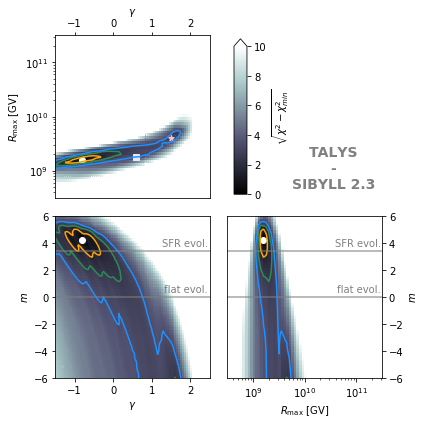

In [13]:
gamma, rmax, m = np.meshgrid(*scan.paramvalues,indexing='ij')
chi2marg = scan.chi2_array - scan.minchi2

from scipy.interpolate import RegularGridInterpolator as RGI

# intp = RGI(tuple(*scan.paramvalues),chi2marg)

fig = plt.figure(figsize=(6,6))

contours = {
    'levels':[2.30,6.18,11.83], # m = 2
    'colors':['orange','seagreen','dodgerblue']
#     'colors':['purple','green','orange']

}

ax = plt.subplot(221)

pcm = plt.pcolormesh(gamma[:,:,0], rmax[:,:,0], np.sqrt(chi2marg).min(axis=2),cmap='bone',vmin=0.,vmax=10.)
con = plt.contour(gamma[:,:,0], rmax[:,:,0], chi2marg.min(axis=2),**contours)
sca = plt.scatter(gamma[scan.minindex],rmax[scan.minindex],c='white')
sca = plt.scatter(gamma[smin_index],rmax[smin_index],c='pink',marker='*')
sca = plt.scatter(gamma[tmin_index],rmax[tmin_index],c='lavender',marker='s')

plt.xlim(gamma.min(),gamma.max())
plt.ylim(rmax.min(),rmax.max())

# plt.xlim(1.,gamma.max())
# plt.ylim(1e10,rmax.max())

plt.semilogy()
plt.xlabel('$\gamma$')
plt.ylabel(r'$R_\mathrm{max}$ [GV]')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax = plt.subplot(223)

pcm = plt.pcolormesh(gamma[:,0,:], m[:,0,:], np.sqrt(chi2marg).min(axis=1),cmap='bone',vmin=0.,vmax=10.)
con = plt.contour(gamma[:,0,:], m[:,0,:], chi2marg.min(axis=1),**contours)
sca = plt.scatter(gamma[scan.minindex],m[scan.minindex],c='white')
#sca = plt.scatter(gamma[smin_index],m[smin_index],c='pink',marker='*')
#sca = plt.scatter(gamma[tmin_index],m[tmin_index],c='lavender',marker='s')

plt.axhline(3.44, c='gray', alpha=0.7)
plt.annotate('SFR evol.', xy=(0.99,3.44 + 0.2), color='gray',
             textcoords=('axes fraction','data'),
             horizontalalignment='right',
             verticalalignment='botton',)
plt.axhline(0.,c='gray', alpha=0.7)
plt.annotate('flat evol.', xy=(0.99,0. + 0.2), color='gray',
             textcoords=('axes fraction','data'),
             horizontalalignment='right',
             verticalalignment='botton',)

plt.xlim(gamma.min(),gamma.max())
plt.ylim(m.min(),m.max())

# plt.xlim(1.,gamma.max())
# plt.ylim(m.min(),m.max())

plt.xlabel('$\gamma$')
plt.ylabel(r'$m$')

ax = plt.subplot(224)

pcm = plt.pcolormesh(rmax[0,:,:], m[0,:,:], np.sqrt(chi2marg).min(axis=0),cmap='bone',vmin=0.,vmax=10.)
con = plt.contour(rmax[0,:,:], m[0,:,:], chi2marg.min(axis=0),**contours)
sca = plt.scatter(rmax[scan.minindex],m[scan.minindex],c='white')
#sca = plt.scatter(rmax[smin_index],m[smin_index],c='pink',marker='*')
#sca = plt.scatter(rmax[tmin_index],m[tmin_index],c='lavender',marker='s')

plt.xlim(rmax.min(),rmax.max())
plt.ylim(m.min(),m.max())

# plt.xlim(1e10,rmax.max())
# plt.ylim(m.min(),m.max())

plt.semilogx()

plt.axhline(3.44, c='gray', alpha=0.7)
plt.annotate('SFR evol.', xy=(3e11,3.44 + 0.2), color='gray',
             horizontalalignment='right',
             verticalalignment='botton',)
plt.axhline(0.,c='gray', alpha=0.7)
plt.annotate('flat evol.', xy=(3e11,0. + 0.2), color='gray',
             horizontalalignment='right',
             verticalalignment='botton',)

plt.xlabel(r'$R_\mathrm{max}$ [GV]')
plt.ylabel(r'$m$')
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position('right')

position = fig.add_axes([0.55,0.54,0.03,0.36])
plt.colorbar(pcm,cax=position, label=r'$\sqrt{\chi^2 - \chi^{2}_{min}}$',extend='max',)

plt.text(0.78,0.6,'TALYS\n-\nSIBYLL 2.3',color='gray',fontsize=14,
         transform=fig.transFigure, weight='semibold',
         horizontalalignment='center', 
         verticalalignment='center',)

plt.tight_layout()
plt.savefig(template.format('paramspace'), dpi=300)
plt.show()

# Example plots, best fit and second minimum

In [14]:
def combine_results(results, fractions, norm):
    return np.sum([res * f for f, res in zip(fractions,results)]) * norm

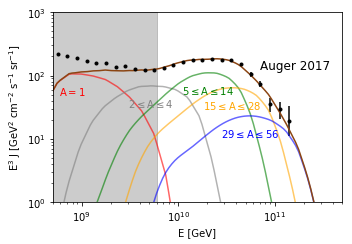

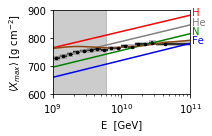

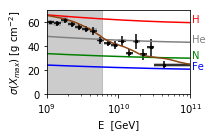

In [15]:
result = scan.get_comb_result(scan.minindex)
deltaE = scan.deltaE_array[scan.minindex]
xshift = scan.xshift_array[scan.minindex]


import matplotlib.pyplot as plt

plt.figure(figsize=(5,3.5))
plot_cosmic_rays(result, deltaE = deltaE)
plt.fill_between([1e8,6e9],1e-1,1e3,color='gray', alpha = 0.4)
plt.ylim(1e0,1e3)
plt.tight_layout()
plt.savefig(template.format('bestfit_spectrum'), dpi=300)
plt.show()

plt.figure(figsize=(3,2))
plot_xmax_mean(result, deltaE = deltaE, xshift = xshift, model=XmaxSimple(XmaxSimple.Sibyll23))
plt.fill_between([1e8,6e9],1e-1,1e3,color='gray', alpha = 0.4)
plt.tight_layout()
plt.savefig(template.format('bestfit_xmax'), dpi=400)
plt.show()

plt.figure(figsize=(3,2))
plot_xmax_sigma(result, deltaE = deltaE, xshift = xshift, model=XmaxSimple(XmaxSimple.Sibyll23))
plt.fill_between([1e8,6e9],1e-1,1e3,color='gray', alpha = 0.4)
plt.tight_layout()
plt.savefig(template.format('bestfit_xrms'), dpi=400)
plt.show()

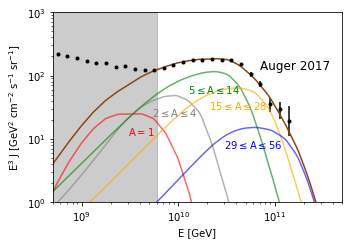

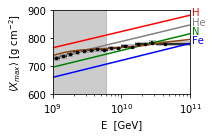

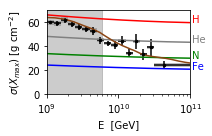

In [16]:
index = smin_index

result = scan.get_comb_result(index)
deltaE = scan.deltaE_array[index]
xshift = scan.xshift_array[index]


import matplotlib.pyplot as plt

plt.figure(figsize=(5,3.5))
plot_cosmic_rays(result, deltaE = deltaE)
plt.fill_between([1e8,6e9],1e-1,1e3,color='gray', alpha = 0.4)
plt.ylim(1e0,1e3)
plt.tight_layout()
plt.savefig(template.format('secondfit_spectrum'), dpi=300)
plt.show()

plt.figure(figsize=(3,2))
plot_xmax_mean(result, deltaE = deltaE, xshift = xshift, model=XmaxSimple(XmaxSimple.Sibyll23))
plt.fill_between([1e8,6e9],1e-1,1e3,color='gray', alpha = 0.4)
plt.tight_layout()
plt.savefig(template.format('secondfit_xmax'), dpi=300)
plt.show()

plt.figure(figsize=(3,2))
plot_xmax_sigma(result, deltaE = deltaE, xshift = xshift, model=XmaxSimple(XmaxSimple.Sibyll23))
plt.fill_between([1e8,6e9],1e-1,1e3,color='gray', alpha = 0.4)
plt.tight_layout()
plt.savefig(template.format('secondfit_xrms'), dpi=300)
plt.show()

# Neutrinos from redshift 1

In [17]:
# m = 2
# exclude_idx exlcudes a single index (in this case there were numerical oscillations)
egrid, band1, _ = scan.comp_neutrino_band(chi_max=2.30,pbar=True)
egrid, band2, _ = scan.comp_neutrino_band(chi_max=6.18,pbar=True, exclude_idx = [(62, 23, 0)])
egrid, band3, _ = scan.comp_neutrino_band(chi_max=11.83,pbar=True)

/afs/ifh.de/group/that/work-jh/packages/PriNCe/prince/solvers.py:118: RuntimeWarning: divide by zero encountered in log
  np.log(curr_spec),


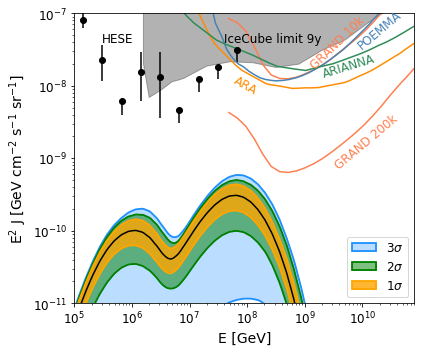

In [18]:
# best_fit
#lower bands
plt.figure(figsize=(6,5))

alpha = 0.3
handles=[]

alpha = 0.3
h1 = plt.fill_between(egrid, band3.min(axis = 0), band3.max(axis =0),
                 alpha = alpha, color = 'dodgerblue',label=r'$3 \sigma$')
h2 = plt.fill_between(egrid, band3.min(axis = 0), band3.max(axis =0),
                 alpha = 1., facecolor = 'none',edgecolor='dodgerblue',linewidth=1.8,linestyle='-')
handles.append((h1,h2))

alpha = 0.5
h1 = plt.fill_between(egrid, band2.min(axis = 0), band2.max(axis =0),
                 alpha = alpha, color = 'green',label=r'$2 \sigma$')
h2 = plt.fill_between(egrid, band2.min(axis = 0), band2.max(axis =0),
                 alpha = 1., facecolor = 'none',edgecolor='green',linewidth=1.8,linestyle='-')
handles.append((h1,h2))

alpha = 0.8
h1 = plt.fill_between(egrid, band1.min(axis = 0), band1.max(axis =0),
                 alpha = alpha, color = 'orange',label=r'$1 \sigma$')
h2 = plt.fill_between(egrid, band1.min(axis = 0), band1.max(axis =0),
                 alpha = 1, facecolor = 'none',edgecolor='orange',linewidth=1.8,linestyle='-')
handles.append((h1,h2))

res = scan.get_comb_result(scan.minindex)
egrid, spec = res.get_solution_group('nu',epow=2)
plt.loglog(egrid,spec,c='black',label='best fit')

from analyzer.spectra import IClimit2017, IClimit2017GRB, IClimit9year
from analyzer.spectra import IClimit9year_new as IClimit9year

plt.fill_between(IClimit9year['energy'], IClimit9year['limit'], np.ones_like(IClimit9year['energy']),
                 color='black',alpha= 0.3)
plt.annotate('IceCube limit 9y',(4e7,4e-8), fontsize = 'large')
# plt.loglog(IClimit9year['energy'], IClimit9year['limit'], color='black')

# from analyzer.spectra import GRAND200K, GRAND10K, ARA, ARIANNA, HESE, Poemma
# from analyzer.spectra import GRAND200K as GRAND200K_old
# from analyzer.spectra import ARIANNA as ARIANNA_old
# from analyzer.spectra import ARIANNA as ARIANNA_old

from analyzer.spectra import GRAND200K_new as GRAND200K
from analyzer.spectra import GRAND10K_new as GRAND10K
from analyzer.spectra import POEMMA_new as Poemma
from analyzer.spectra import ARA_new as ARA
from analyzer.spectra import ARIANNA_new as ARIANNA
from analyzer.spectra import HESE

plt.loglog(GRAND200K['energy'], GRAND200K['limit'], color='coral')
plt.annotate('GRAND 200k',(4e9,7e-10), fontsize = 'large', color='coral', rotation=40, rotation_mode='anchor')

plt.loglog(GRAND10K['energy'], GRAND10K['limit'], color='coral')
plt.annotate('GRAND 10k',(1.5e9,1.7e-8), fontsize = 'large', color='coral', rotation=44, rotation_mode='anchor')

plt.loglog(Poemma['energy'], Poemma['limit'], color='steelblue')
plt.annotate('POEMMA',(1e10,3.2e-8), fontsize = 'large', color='steelblue', rotation=40, rotation_mode='anchor')

plt.loglog(ARA['energy'], ARA['limit'], color='darkorange')
plt.annotate('ARA',(5.6e7,1.1e-8), fontsize = 'large', color='darkorange', rotation=-29, rotation_mode='anchor')

plt.loglog(ARIANNA['energy'], ARIANNA['limit'], color='seagreen')
plt.annotate('ARIANNA',(2.2e9,1.3e-8), fontsize = 'large', color='seagreen', rotation=17, rotation_mode='anchor')

plt.errorbar(HESE['energy'].value, HESE['flux'].value,
             yerr=(HESE['lower_err'].value, HESE['upper_err'].value),
             fmt='o',c='black')
plt.annotate('HESE',(3e5,4e-8), fontsize = 'large', color='black', rotation=0, rotation_mode='anchor')

# plt.xlim(IClimit2017['energy'][0].value,IClimit2017['energy'][-1].value)
# plt.xlim(IClimit2017['energy'][0].value,1e11)
plt.ylim(1e-11,1e-7)
plt.xlim(1e5,IClimit9year['energy'][-1].value)

plt.legend(loc='lower right')
plt.legend(handles,(r'$3 \sigma$',r'$2 \sigma$',r'$1 \sigma$'),loc='lower right',fontsize=12)

plt.ylabel('E$^2$ J [GeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$]',fontsize=14)
plt.xlabel('E [GeV]',fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(template.format('neutrinos'), dpi=300)
plt.show()